<a href="https://colab.research.google.com/github/DJCordhose/ml-workshop/blob/master/notebooks/intro/2021/intro_rnn_basics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sequences and RNNs

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (20, 8)

In [3]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

In [4]:
import tensorflow as tf
print(tf.__version__)

2.4.1


In [5]:
# https://github.com/AndreasMadsen/python-lrcurve
!pip install -q lrcurve

     |████████████████████████████████| 71kB 7.3MB/s 


In [6]:
from lrcurve import KerasLearningCurve

In [7]:
# https://keras.io/metrics/#custom-metrics
# https://www.tensorflow.org/tutorials/customization/performance
  
# ported to TF 2 from 
# * https://stackoverflow.com/a/42351397/1756489 and
# * https://www.kaggle.com/c/mercedes-benz-greener-manufacturing/discussion/34019 (for use of epsilon to avoid strange inf or -inf)

# only works properly on tensors

@tf.function
def r2_metric(y_true, y_pred):
  total_error = tf.reduce_sum(tf.square(tf.subtract(y_true, tf.reduce_mean(y_true))))
  unexplained_error = tf.reduce_sum(tf.square(tf.subtract(y_true, y_pred)))
  R_squared = tf.subtract(1.0, tf.divide(unexplained_error, tf.add(total_error, tf.keras.backend.epsilon())))
  
  return R_squared

# Univariate Sequences

just one variable per time step

### Challenge

We have a known series of events, possibly in time and you want to know what is the next event. Like this

[10, 20, 30, 40, 50, 60, 70, 80, 90]

In [8]:
import numpy as np

# derived from here: https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/
# something like this is also possible, but timeseries_dataset_from_array is a bit weird
# dataset = tf.keras.preprocessing.timeseries_dataset_from_array(data=data[:-n_steps], targets=data[n_steps:], sequence_length=n_steps)
# for batch in dataset:
#     inputs, targets = batch
#     print(inputs)
#     print(targets)
#     break

# split sequence into samples
def split_sequence(sequence, n_steps_in, n_steps_out=1):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		# check if we are beyond the sequence
		if out_end_ix > len(sequence):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)
 

In [9]:
raw_seq = np.arange(10, 100, 10)
raw_seq

array([10, 20, 30, 40, 50, 60, 70, 80, 90])

In [10]:
#@title Prediction from n past steps { run: "auto", display-mode: "both" }

# https://colab.research.google.com/notebooks/forms.ipynb

n_steps = 3 #@param {type:"slider", min:1, max:10, step:1}

# split into samples
X, y = split_sequence(raw_seq, n_steps)

# summarize the data
list(zip(X, y))

[(array([10, 20, 30]), array([40])),
 (array([20, 30, 40]), array([50])),
 (array([30, 40, 50]), array([60])),
 (array([40, 50, 60]), array([70])),
 (array([50, 60, 70]), array([80])),
 (array([60, 70, 80]), array([90]))]

### Converting shapes

* one of the most frequent, yet most tedious steps
* match between what you have and what an interface needs
* expected input of RNN: 3D tensor with shape (samples, timesteps, input_dim)
* we have: (samples, timesteps)
* reshape on np arrays can do all that

In [11]:
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))
X

array([[[10],
        [20],
        [30]],

       [[20],
        [30],
        [40]],

       [[30],
        [40],
        [50]],

       [[40],
        [50],
        [60]],

       [[50],
        [60],
        [70]],

       [[60],
        [70],
        [80]]])

In [12]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, LSTM, GRU, SimpleRNN, Bidirectional
from tensorflow.keras.models import Sequential, Model

model = Sequential()
model.add(SimpleRNN(units=50, activation='relu', input_shape=(n_steps, n_features), name="RNN_Input"))
model.add(Dense(units=1, name="Linear_Output"))
model.compile(optimizer='adam', loss='mse', metrics=[r2_metric])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
RNN_Input (SimpleRNN)        (None, 50)                2600      
_________________________________________________________________
Linear_Output (Dense)        (None, 1)                 51        
Total params: 2,651
Trainable params: 2,651
Non-trainable params: 0
_________________________________________________________________


In [13]:
EPOCHS = 1000

%time history = model.fit(X, y, epochs=EPOCHS, callbacks=[KerasLearningCurve()], verbose=0)

CPU times: user 10.7 s, sys: 1.24 s, total: 11.9 s
Wall time: 14.9 s


In [14]:
loss, r2 = model.evaluate(X, y, verbose=0)
loss, r2

(0.0008346519316546619, 0.9999971389770508)

### Let's try this on a few examples

In [15]:
# this does not look too bad
X_sample = np.array([[10, 20, 30], [70, 80, 90]]).astype(np.float32)
X_sample = X_sample.reshape((X_sample.shape[0], X_sample.shape[1], n_features))
X_sample

array([[[10.],
        [20.],
        [30.]],

       [[70.],
        [80.],
        [90.]]], dtype=float32)

In [16]:
y_pred = model.predict(X_sample)
y_pred

array([[ 39.95873 ],
       [100.458206]], dtype=float32)

In [17]:
def predict(model, samples, n_features=1):
  input = np.array(samples).astype(np.float32)
  input = input.reshape((input.shape[0], input.shape[1], n_features))
  y_pred = model.predict(input)
  return y_pred

In [18]:
# do not look too close, though
predict(model, [[100, 110, 120], [200, 210, 220], [200, 300, 400]])

array([[132.00406],
       [237.56975],
       [480.8573 ]], dtype=float32)

# Hands-On: Traing your first RNN

* go through the notebook as it is
* Try to improve the model
  * Change the number of values used as input
  * Change activation function
  * More nodes? less nodes?
  * What else might help improving the results?


# Input and output of an RNN layer

In [19]:
# https://keras.io/layers/recurrent/
# input: (samples, timesteps, input_dim)
# output: (samples, units)

# let's have a look at the actual output for an example
rnn_layer = model.get_layer("RNN_Input")
model_stub = Model(inputs = model.input, outputs = rnn_layer.output)
hidden = predict(model_stub, [[10, 20, 30]])
hidden.shape, hidden

((1, 50), array([[7.8043923e+00, 3.5281258e+00, 0.0000000e+00, 6.1574678e+00,
         0.0000000e+00, 2.8751664e+00, 2.1826090e+01, 4.3139315e+00,
         9.3859539e+00, 0.0000000e+00, 1.0779451e+01, 1.1416330e+01,
         0.0000000e+00, 5.0719056e+00, 6.2402201e+00, 0.0000000e+00,
         0.0000000e+00, 4.2754488e+00, 8.8766327e+00, 0.0000000e+00,
         2.0691399e+01, 0.0000000e+00, 6.9864016e+00, 2.4844408e-03,
         1.3634480e+00, 0.0000000e+00, 1.1131761e+01, 1.2207252e+01,
         1.0977322e+01, 0.0000000e+00, 2.1629055e+00, 0.0000000e+00,
         0.0000000e+00, 0.0000000e+00, 1.2647115e+01, 0.0000000e+00,
         2.1362181e+00, 0.0000000e+00, 0.0000000e+00, 1.9760132e-03,
         1.2626048e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
         0.0000000e+00, 4.5480399e+00, 1.0292160e+01, 1.4192848e+01,
         2.1102619e-01, 5.9054055e+00]], dtype=float32))

#### What do we see?
* each unit (50) has a single output
* as a sidenote you nicely see the RELU nature of the output
* so the timesteps of the input are lost
* we are only looking at the final output
* still with each timestep, the layer does produce a unique output we could potentially use

### We need to look into RNNs a bit more deeply now

#### RNNs - Networks with Loops
<img src='https://djcordhose.github.io/ai/img/nlp/colah/RNN-rolled.png' height=200>

http://colah.github.io/posts/2015-08-Understanding-LSTMs/
#### Unrolling the loop
<img src='https://djcordhose.github.io/ai/img/nlp/colah/RNN-unrolled.png'>

http://colah.github.io/posts/2015-08-Understanding-LSTMs/
#### Simple RNN internals

<img src='https://djcordhose.github.io/ai/img/nlp/fchollet_rnn.png'>

##  $output_t = \tanh(W input_t + U output_{t-1} + b)$

From Deep Learning with Python, Chapter 6, François Chollet, Manning: https://livebook.manning.com/#!/book/deep-learning-with-python/chapter-6/129

#### Activation functions

<img src='https://djcordhose.github.io/ai/img/sigmoid-activation.png' height=200>

Sigmoid compressing between 0 and 1

<img src='https://djcordhose.github.io/ai/img/tanh-activation.png' height=200>

Hyperbolic tangent, like sigmoind, but compressing between -1 and 1, thus allowing for negative values as well

# Multi Layer RNNs

In [20]:
# one output for each input timestep
# ideal for feeding into something that *expects* timesteps
rnn_units = 1

from tensorflow.keras.layers import Dense, LSTM, GRU, SimpleRNN, Bidirectional
from tensorflow.keras.models import Sequential, Model

model = Sequential([
    SimpleRNN(units=rnn_units, activation='relu', return_sequences=True),
    # SimpleRNN(units=rnn_units, activation='relu')
])

# https://keras.io/layers/recurrent/
# input: (samples, timesteps, input_dim)
# output with return_sequences: (samples, timesteps, units)

predict(model, [[10, 20, 30]])

array([[[ 8.811184],
        [26.433552],
        [52.867104]]], dtype=float32)

In [21]:
rnn_units = 50

model = Sequential([
    SimpleRNN(units=rnn_units, activation='relu', input_shape=(n_steps, n_features), return_sequences=True, name="RNN_Input"),
    SimpleRNN(units=rnn_units, activation='relu', name="RNN_Latent"),
    Dense(units=1, name="Linear_Output")
])
model.compile(optimizer='adam', loss='mse', metrics=[r2_metric])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
RNN_Input (SimpleRNN)        (None, 3, 50)             2600      
_________________________________________________________________
RNN_Latent (SimpleRNN)       (None, 50)                5050      
_________________________________________________________________
Linear_Output (Dense)        (None, 1)                 51        
Total params: 7,701
Trainable params: 7,701
Non-trainable params: 0
_________________________________________________________________


In [22]:
%time history = model.fit(X, y, epochs=2000, callbacks=[KerasLearningCurve()], verbose=0)

CPU times: user 28.7 s, sys: 3.15 s, total: 31.8 s
Wall time: 32.2 s


In [23]:
loss, r2 = model.evaluate(X, y, verbose=0)
loss, r2

(0.00024000108533073217, 0.9999991655349731)

In [24]:
predict(model, [[10, 20, 30], [70, 80, 90], [100, 110, 120], [200, 210, 220], [200, 300, 400]])

array([[ 39.976112],
       [102.18896 ],
       [138.7256  ],
       [260.9738  ],
       [488.96024 ]], dtype=float32)

### LSMTs / GRUs

* mainly beneficial for long sequences
* but also 3-4 times more expensive
* might not have better results for short sequences like these

### LSTM

In [25]:
rnn_units = 50

model = Sequential([
    LSTM(units=rnn_units, activation='relu', input_shape=(n_steps, n_features), name="RNN_Input"),
    Dense(units=1, name="Linear_Output")
])
model.compile(optimizer='adam', loss='mse', metrics=[r2_metric])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
RNN_Input (LSTM)             (None, 50)                10400     
_________________________________________________________________
Linear_Output (Dense)        (None, 1)                 51        
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


In [26]:
%time history = model.fit(X, y, epochs=2000, callbacks=[KerasLearningCurve()], verbose=0)

CPU times: user 29.6 s, sys: 3.6 s, total: 33.2 s
Wall time: 32.9 s


In [27]:
loss, r2 = model.evaluate(X, y, verbose=0)
loss, r2

(0.0007574281771667302, 0.9999973773956299)

In [28]:
predict(model, [[10, 20, 30], [70, 80, 90], [100, 110, 120], [200, 210, 220], [200, 300, 400]])

array([[ 39.98703],
       [100.17986],
       [132.17308],
       [245.13947],
       [334.26294]], dtype=float32)

### GRU

In [29]:
rnn_units = 50

model = Sequential([
    GRU(units=rnn_units, activation='relu', input_shape=(n_steps, n_features), name="RNN_Input"),
    Dense(units=1, name="Linear_Output")
])
model.compile(optimizer='adam', loss='mse', metrics=[r2_metric])
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
RNN_Input (GRU)              (None, 50)                7950      
_________________________________________________________________
Linear_Output (Dense)        (None, 1)                 51        
Total params: 8,001
Trainable params: 8,001
Non-trainable params: 0
_________________________________________________________________


In [30]:
%time history = model.fit(X, y, epochs=2000, callbacks=[KerasLearningCurve()], verbose=0)

CPU times: user 33.6 s, sys: 4.55 s, total: 38.1 s
Wall time: 35.7 s


In [31]:
loss, r2 = model.evaluate(X, y, verbose=0)
loss, r2

(0.0003681278321892023, 0.9999987483024597)

In [32]:
predict(model, [[10, 20, 30], [70, 80, 90], [100, 110, 120], [200, 210, 220], [200, 300, 400]])

array([[ 40.000114],
       [100.37922 ],
       [132.61937 ],
       [245.07341 ],
       [379.84534 ]], dtype=float32)

# Multivariate LSTM Models

## Multiple Input Series

In [33]:
in_seq1 = [10, 20, 30, 40, 50, 60, 70, 80, 90]
in_seq2 = [15, 25, 35, 45, 55, 65, 75, 85, 95]
out_seq = [in1 + in2 for in1, in2 in zip(in_seq1, in_seq2)]
out_seq

[25, 45, 65, 85, 105, 125, 145, 165, 185]

In [34]:
# convert to [rows, columns] structure
in_seq1 = np.array(in_seq1).reshape((len(in_seq1), 1))
in_seq2 = np.array(in_seq2).reshape((len(in_seq2), 1))
out_seq = np.array(out_seq).reshape((len(out_seq), 1))
out_seq

array([[ 25],
       [ 45],
       [ 65],
       [ 85],
       [105],
       [125],
       [145],
       [165],
       [185]])

In [35]:
# horizontally stack columns
dataset = np.hstack((in_seq1, in_seq2, out_seq))
dataset

array([[ 10,  15,  25],
       [ 20,  25,  45],
       [ 30,  35,  65],
       [ 40,  45,  85],
       [ 50,  55, 105],
       [ 60,  65, 125],
       [ 70,  75, 145],
       [ 80,  85, 165],
       [ 90,  95, 185]])

In [36]:
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the dataset
		if end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

In [37]:
#@title Prediction from n past steps { run: "auto", display-mode: "both" }

# https://colab.research.google.com/notebooks/forms.ipynb

n_steps = 3 #@param {type:"slider", min:1, max:10, step:1}

# convert into input/output
X, y = split_sequences(dataset, n_steps)

# summarize the data
list(zip(X, y))

[(array([[10, 15],
         [20, 25],
         [30, 35]]), 65), (array([[20, 25],
         [30, 35],
         [40, 45]]), 85), (array([[30, 35],
         [40, 45],
         [50, 55]]), 105), (array([[40, 45],
         [50, 55],
         [60, 65]]), 125), (array([[50, 55],
         [60, 65],
         [70, 75]]), 145), (array([[60, 65],
         [70, 75],
         [80, 85]]), 165), (array([[70, 75],
         [80, 85],
         [90, 95]]), 185)]

In [38]:
# the dataset knows the number of features, e.g. 2
n_features = X.shape[2]

# define model
model = Sequential()
model.add(GRU(units=50, activation='relu', input_shape=(n_steps, n_features), name="RNN_Input"))
model.add(Dense(units=1, name="Linear_Output"))
model.compile(optimizer='adam', loss='mse', metrics=[r2_metric])

In [39]:
%time history = model.fit(X, y, epochs=2000, callbacks=[KerasLearningCurve()], verbose=0)

CPU times: user 33.8 s, sys: 4.28 s, total: 38.1 s
Wall time: 35.7 s


In [40]:
loss, r2 = model.evaluate(X, y, verbose=0)
loss, r2

(0.00034594390308484435, 0.9999997615814209)

In [41]:
def predict_multi(model, samples):
  input = np.array(samples).astype(np.float32)
  input = input.reshape(1, input.shape[0], input.shape[1])
  y_pred = model.predict(input)
  return y_pred

In [42]:
predict_multi(model, [[80, 85], [90, 95], [100, 105]])

array([[205.50334]], dtype=float32)

In [43]:
predict_multi(model, [[10, 15], [20, 25], [30, 35]])

array([[65.002625]], dtype=float32)

In [44]:
predict_multi(model, [[180, 185], [190, 195], [200, 205]])

array([[415.17505]], dtype=float32)

#### Let's make this a little bit harder

* output y can be inferred from final timestep
* now we try to infer following ouput

In [45]:
y += 20
list(zip(X, y))

[(array([[10, 15],
         [20, 25],
         [30, 35]]), 85), (array([[20, 25],
         [30, 35],
         [40, 45]]), 105), (array([[30, 35],
         [40, 45],
         [50, 55]]), 125), (array([[40, 45],
         [50, 55],
         [60, 65]]), 145), (array([[50, 55],
         [60, 65],
         [70, 75]]), 165), (array([[60, 65],
         [70, 75],
         [80, 85]]), 185), (array([[70, 75],
         [80, 85],
         [90, 95]]), 205)]

In [46]:
model = Sequential()
model.add(GRU(units=50, activation='relu', input_shape=(n_steps, n_features), name="RNN_Input"))
model.add(Dense(units=1, name="Linear_Output"))
model.compile(optimizer='adam', loss='mse', metrics=[r2_metric])

%time history = model.fit(X, y, epochs=2000, callbacks=[KerasLearningCurve()], verbose=0)

CPU times: user 33.8 s, sys: 4.25 s, total: 38.1 s
Wall time: 35.5 s


In [47]:
loss, r2 = model.evaluate(X, y, verbose=0)
loss, r2

(0.0002189934893976897, 0.9999998807907104)

In [48]:
predict_multi(model, [[80, 85], [90, 95], [100, 105]])

array([[225.97325]], dtype=float32)

In [49]:
predict_multi(model, [[10, 15], [20, 25], [30, 35]])

array([[85.001625]], dtype=float32)

In [50]:
predict_multi(model, [[180, 185], [190, 195], [200, 205]])

array([[449.50543]], dtype=float32)

## Multi-Step LSTM Models
* this might just as well be an encoder / decoder approach

In [51]:
raw_seq = np.arange(10, 100, 10)
raw_seq

array([10, 20, 30, 40, 50, 60, 70, 80, 90])

In [52]:

#@title Prediction from n past steps { run: "auto", display-mode: "both" }

# https://colab.research.google.com/notebooks/forms.ipynb

n_steps_in = 3 #@param {type:"slider", min:1, max:10, step:1}
n_steps_out = 2 #@param {type:"slider", min:1, max:10, step:1}

X, y = split_sequence(raw_seq, n_steps_in, n_steps_out)

for input, output in zip(X, y):
  print (input, output)

[10 20 30] [40 50]
[20 30 40] [50 60]
[30 40 50] [60 70]
[40 50 60] [70 80]
[50 60 70] [80 90]


In [53]:
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))
# define model
model = Sequential()
model.add(GRU(100, activation='relu', input_shape=(n_steps_in, n_features)))
# model.add(GRU(100, activation='relu', return_sequences=True, input_shape=(n_steps_in, n_features)))
# model.add(GRU(100, activation='relu'))
model.add(Dense(n_steps_out))
model.compile(optimizer='adam', loss='mse', metrics=[r2_metric])

%time history = model.fit(X, y, epochs=2000, callbacks=[KerasLearningCurve()], verbose=0)

CPU times: user 34 s, sys: 4.39 s, total: 38.4 s
Wall time: 35.8 s


In [54]:
loss, r2 = model.evaluate(X, y, verbose=0)
loss, r2

(4.978108449904539e-07, 1.0)

In [55]:
X_sample = np.array([70, 80, 90]).reshape((1, n_steps_in, n_features)).astype(np.float32)
y_pred = model.predict(X_sample)
print(y_pred)

[[100.971375 112.25148 ]]


In [56]:
X_sample = np.array([10, 20, 30]).reshape((1, n_steps_in, n_features)).astype(np.float32)
y_pred = model.predict(X_sample)
print(y_pred)

[[40.00019 50.00024]]


# Hands-On: Fit hand drawn data 

In [57]:
 !pip install -q drawdata

     |████████████████████████████████| 788kB 11.1MB/s 
     |████████████████████████████████| 368kB 32.0MB/s 
ERROR: jupyter-console 5.2.0 has requirement prompt-toolkit<2.0.0,>=1.0.0, but you'll have prompt-toolkit 3.0.18 which is incompatible.
ERROR: google-colab 1.0.0 has requirement ipython~=5.5.0, but you'll have ipython 7.22.0 which is incompatible.


In [58]:
from drawdata import draw_line, draw_scatter, draw_histogram

draw_line()

In [86]:
drawdata_data = """
x,y,z
41,126,a
45,129,a
49,131,a
51,135,a
56,140,a
58,145,a
62,157,a
66,164,a
68,167,a
70,171,a
70,173,a
72,175,a
73,179,a
74,181,a
77,185,a
79,188,a
83,192,a
86,194,a
90,199,a
91,200,a
94,202,a
95,204,a
97,206,a
98,207,a
100,209,a
105,215,a
109,219,a
113,223,a
119,228,a
121,230,a
123,232,a
127,236,a
129,237,a
132,239,a
136,242,a
140,243,a
142,245,a
147,246,a
149,247,a
151,247,a
157,247,a
161,247,a
166,247,a
171,247,a
172,247,a
174,247,a
176,247,a
177,246,a
179,243,a
180,242,a
182,241,a
182,238,a
182,236,a
183,234,a
183,232,a
183,231,a
183,230,a
184,227,a
184,222,a
185,221,a
185,220,a
187,218,a
187,215,a
187,213,a
187,211,a
188,210,a
189,209,a
190,206,a
191,204,a
191,203,a
193,201,a
195,200,a
196,197,a
197,196,a
198,194,a
198,193,a
200,190,a
201,187,a
203,185,a
206,180,a
209,176,a
210,173,a
215,164,a
218,159,a
220,157,a
223,152,a
224,148,a
225,146,a
227,141,a
230,139,a
231,137,a
232,134,a
233,133,a
234,131,a
236,127,a
237,126,a
237,122,a
239,120,a
241,117,a
242,113,a
245,108,a
248,107,a
251,105,a
255,103,a
258,103,a
259,103,a
260,103,a
264,103,a
267,103,a
269,104,a
274,104,a
278,106,a
282,108,a
286,109,a
290,111,a
293,113,a
296,114,a
298,116,a
300,117,a
304,120,a
306,122,a
311,125,a
316,128,a
322,131,a
325,132,a
332,137,a
335,141,a
341,148,a
349,162,a
355,170,a
358,179,a
360,194,a
362,203,a
363,210,a
363,217,a
363,220,a
365,225,a
366,233,a
369,238,a
370,244,a
373,252,a
374,257,a
377,259,a
379,263,a
380,266,a
381,269,a
383,271,a
386,277,a
388,281,a
391,288,a
397,303,a
401,318,a
402,326,a
402,330,a
402,331,a
402,333,a
403,336,a
404,336,a
405,336,a
405,337,a
407,336,a
407,334,a
409,328,a
410,324,a
410,322,a
410,320,a
410,319,a
412,316,a
413,314,a
414,312,a
416,307,a
419,303,a
421,300,a
422,298,a
426,293,a
429,287,a
431,282,a
436,272,a
437,267,a
440,261,a
442,255,a
445,250,a
448,244,a
454,236,a
456,232,a
459,225,a
462,219,a
463,212,a
466,205,a
469,193,a
470,186,a
473,179,a
476,170,a
479,162,a
482,152,a
486,140,a
488,133,a
488,128,a
488,126,a
488,125,a
488,124,a
488,122,a
488,126,a
488,129,a
488,131,a
489,135,a
490,142,a
493,155,a
498,166,a
503,181,a
507,202,a
509,209,a
512,215,a
514,222,a
517,228,a
523,235,a
526,242,a
532,252,a
533,258,a
534,260,a
536,262,a
536,264,a
536,266,a
536,265,a
536,264,a
537,263,a
537,260,a
537,258,a
537,257,a
537,256,a
542,248,a
544,239,a
549,228,a
553,215,a
556,208,a
556,206,a
556,201,a
556,200,a
556,199,a
559,191,a
560,186,a
562,179,a
562,175,a
562,174,a
562,172,a
562,171,a
563,171,a
564,171,a
565,171,a
566,171,a
568,171,a
570,171,a
571,173,a
575,175,a
581,178,a
583,179,a
588,180,a
593,182,a
595,185,a
599,186,a
605,189,a
609,192,a
612,194,a
618,197,a
621,199,a
624,202,a
627,204,a
629,206,a
630,207,a
634,210,a
636,211,a
639,213,a
642,216,a
646,218,a
648,219,a
652,221,a
654,223,a
657,225,a
658,226,a
660,227,a
662,229,a
665,231,a
667,232,a
668,233,a
670,233,a
672,234,a
674,235,a
676,238,a
677,238,a
678,240,a
681,241,a
683,242,a
685,244,a
687,246,a
689,247,a
690,248,a
692,250,a
694,251,a
694,252,a
695,252,a
"""

In [87]:
from io import StringIO
import pandas as pd

df = pd.read_csv(StringIO(drawdata_data))
df.head()

x    y  z
0  41  126  a
1  45  129  a
2  49  131  a
3  51  135  a
4  56  140  a

In [88]:
df['x'] = df['x'] - df['x'].min()
df['timestamp'] = pd.to_datetime(df['x'], unit='s')
df = df.drop_duplicates(subset='timestamp', keep='last')
df = df.set_index('timestamp', drop=True)
df.drop(['x', 'z'], axis=1, inplace=True)
df = df.resample('S').interpolate()
data = df['y'].to_numpy()

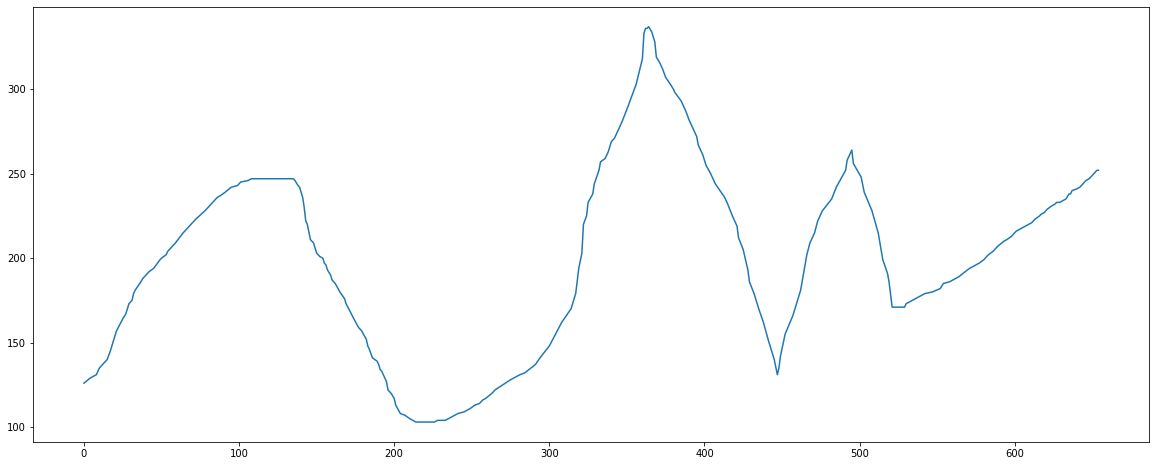

In [89]:
plt.plot(data);

In [90]:
#@title Prediction from n past steps { run: "auto", display-mode: "both" }

# https://colab.research.google.com/notebooks/forms.ipynb

n_steps_in = 30 #@param {type:"slider", min:1, max:100, step:1}
n_steps_out = 1

X, Y = split_sequence(data, n_steps_in, n_steps_out)
X.shape, Y.shape

((625, 30), (625, 1))

In [91]:
# reshape from [samples, timesteps] to [samples, timesteps, features]
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))
X.shape

(625, 30, 1)

In [92]:
# we do a special test / train split, 
split_point = round(X.shape[0] * 0.4)

X_train = X[:-split_point]
Y_train = Y[:-split_point]

X_test = X[-split_point:]
Y_test = Y[-split_point:]

X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((375, 30, 1), (375, 1), (250, 30, 1), (250, 1))

In [99]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, LSTM, GRU, SimpleRNN, Bidirectional
from tensorflow.keras.models import Sequential, Model

model = Sequential()
model.add(SimpleRNN(units=50, activation='relu', input_shape=(n_steps, n_features), name="RNN_Input"))
model.add(Dense(units=1, name="Linear_Output"))
model.compile(optimizer='adam', loss='mse', metrics=[r2_metric])


In [100]:
%%time

batch_size = 32
epochs=25

history = model.fit(X_train, Y_train, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=(X_test, Y_test),
                    callbacks=[KerasLearningCurve()], 
                    verbose=0)

CPU times: user 10.9 s, sys: 1.08 s, total: 12 s
Wall time: 8.2 s


In [101]:
# R2 score will be distorted if not done on all samples
loss, r2 = model.evaluate(X, Y, batch_size=len(X), verbose=0)

r2

0.9955436587333679

In [102]:
Y_pred = model.predict(X)

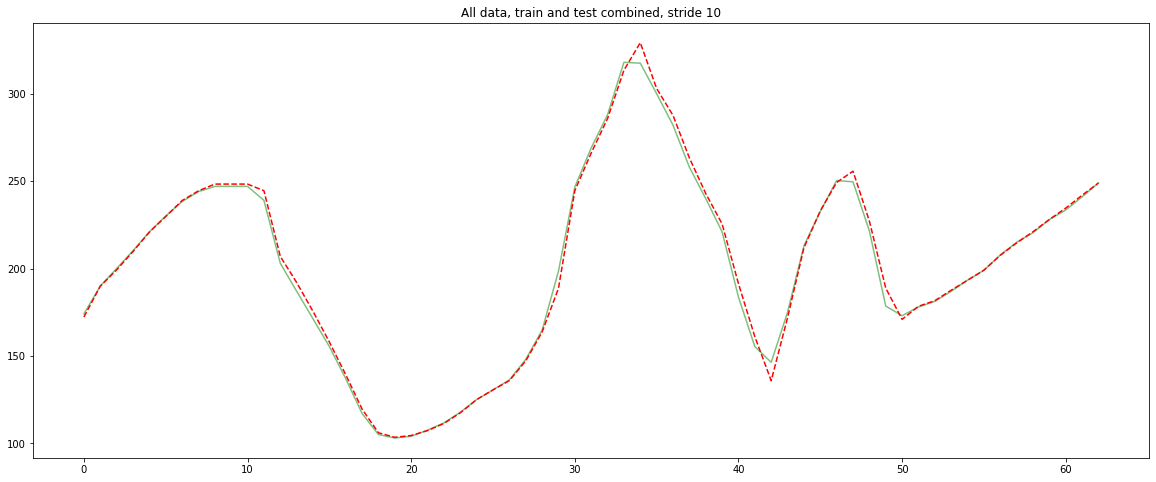

In [103]:
# this gets really crowded, using a stride, makes it more readable
stride = 10

# for the first 90 days we have no prediction, so get rid of them
plt.plot(data[n_steps_in::stride], alpha=0.5, color='g')
plt.plot(Y_pred[::stride], color='r', ls='dashed')

plt.title('All data, train and test combined, stride 10');


In [98]:
# your code goes here

In [83]:
drawdata_data = """
COPY CSV AND MANUALLY PASTE CSV DATA HERE
"""